#### El top 10 de los jugadores con mejor puntaje heroico. 
El puntaje PH de un jugador i se calcula como:

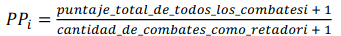

1. El primer job se encarga de dejar la información relevante y que nos interesa correctamente agrupada. El mapper que ejecuta el `fmapBase` corre sobre los datos contabilizados previamente por en el punto 2 de este mismo trabajo. El segundo mapper usa `fmapPartida` que recupera para cada retado el retador a quien le tendrá que pasar su PP y PH, el retado funciona como jugador J. El reducer recibe ambas cosas y escribe el jugador, su puntaje promedio, su puntaje historico, su puntaje historico viejo y la persona a quien le tiene que enviar sus datos. Además escribimos los datos puros del jugador con retador -1 para saber que esos son mis datos.
2. El segundo Job calcula el PH en esta iteración. El mapper distingue si lo que tenemos son DATOS o CONTRIBUCIONES en base a la columna del retador que habiamos planteado. Como es importante que me lleguen primero mis datos y luego las contribuciones hacemos uso del shuffle y sort personalizados. El reducer calcula el PH en base a la formula dada.
3. Hacemos uso de un tercer job que calculara el error absoluto medio (MAE). Es necesario porque los jugadores son BIG DATA. En base a este resultado es que consideramos seguir iterando o no. El MAE se calcula como todos los Ph_nuevos - PH_viejo (en valor absoluto) y un promedio de los mismos.
4. Este job solo se ejecuta en caso de que el PH no llegue a un punto aceptable, lo que llamamos `error_tolerado`. Se encarga de hacer el trabajo similar al format, prepara la proxima iteración
5. Debido a que a este punto solo tenemos un listado de todos los jugadores sin repeticiones pero sigue siendo big data hacemos uso de un último job que calcula el top 10. Envia todos los datos a un reducer que realiza una max heap. Si tengo algo que más chico que el PH que acabo de recibir cambio el dato por el nuevo.


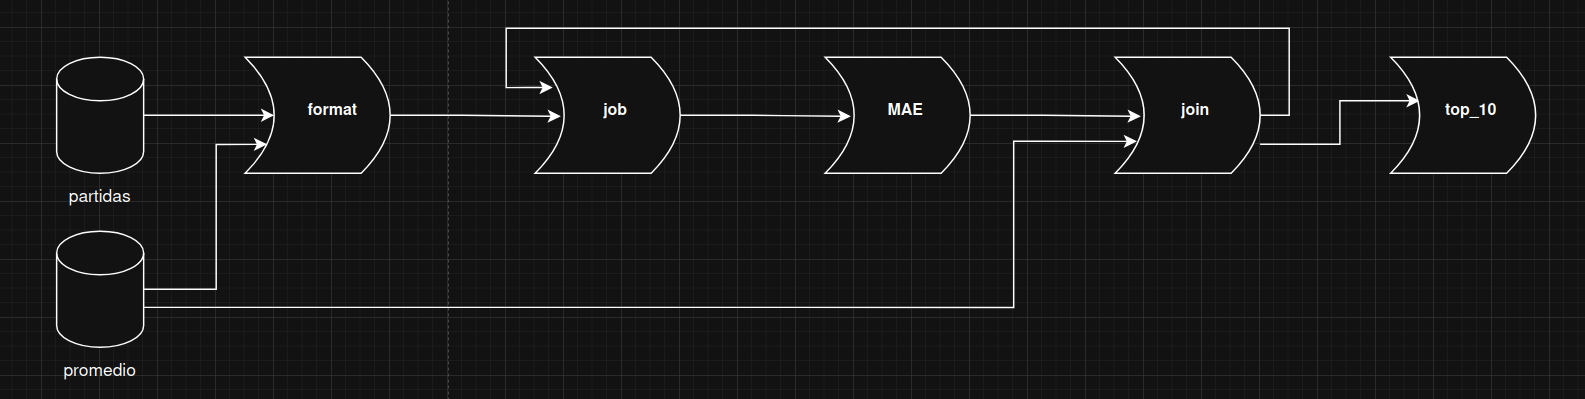

Recalco que format solo será entrada en la primera iteración y join todas las demás

# Primer Job 
Escribe en el archivo format para cada jugador su puntaje promedio y su puntaje historico nuevo y anterior (en la primera vuelta son iguales) y si alguien lo reto

In [64]:
from MRE import Job
partidasDir = "./partidas/"
promedioDir = "../punto2/contabilizado/"
outputDir = "./format/"

In [ ]:
def fmapBase(key, value, context):
    lista = value.split()
    ph = 1
    if lista[0] == '0' and lista[1] == '0':
        promedio = 1/1
    else:
        promedio = (int(lista[0])  )/(int(lista[1])) 
    context.write((int(key), "PP"), (promedio,ph))

def fmapPartida(retador, value, context):
    lista = value.split("\t")
    retado = lista[0]
    context.write((int(retado), "SENT TO"), int(retador))

def cmpShort(key1,key2):
    if(key1[0] == key2[0]):
        return 0
    elif(key1[0] < key2[0]):
        return -1
    else:
        return 1
    
def cmpShuffle(key1, key2):
    if(key1[1] == key2[1]):
        return 0
    elif(key1[1] == "PP"): #PP y PH es el primero 
        return -1
    else:
        return 1 #Caso Contribucion
    
def fred(key, values, context):
    estructura = next(values) 
    # Estructura esperada: [PP_i , PH_viejo]
    pp_i = float(estructura[0])
    ph = estructura[1]
    
    for v in values: 
        retador = v
        context.write(key[0], (pp_i, puntaje_heroico_inicial, ph, retador))

    context.write(key[0], (pp_i, puntaje_heroico_inicial, ph,-1)) 
puntaje_heroico_inicial = 1

jobFormat = Job(promedioDir, outputDir, fmapBase, fred)
jobFormat.setParams(puntaje_heroico_inicial)
jobFormat.addInputPath(partidasDir, fmapPartida)
jobFormat.setShuffleCmp(cmpShort)
jobFormat.setSortCmp(cmpShuffle)

success = jobFormat.waitForCompletion()

print(success)

True


# Segundo job  = iterador
Toma la salida del job anterior para saber los datos de cada jugador contribuir al calculo de quienes lo retaron (si nadie lo reto no envia info)

In [66]:
retadores = set()
retados = set()
all = set()
with open(partidasDir+"datos.txt", "r") as f:
    for linea in f:
        datos = linea.split("\t")
        all.add(int(datos[0]))
        all.add(int(datos[1]))
        retadores.add(int(datos[0]))
        retados.add(int(datos[1]))
print(f"Retadores que no fueron retados: {retadores - retados}")
print(f"Retados que no fueron retadores: {retados - retadores}")
print(len(all))

Retadores que no fueron retados: {3, 102, 103, 7, 113, 116}
Retados que no fueron retadores: {2, 99, 101, 6, 105, 106, 139, 112, 114, 119, 24, 92}
112


In [67]:

def fmapJugador(key, value, context):
    lista = value.split("\t")
    promedio = lista[0]
    ph_inicial = lista[1]
    ph_viejo = lista[2]
    if lista[3] == "-1":
        context.write((int(key), "DATOS"), (promedio, ph_inicial, ph_viejo))
    if lista[3] != "-1":  # Evitar casos sin retadores (este caso se da si un jugador no fue retado por a nadie)
        retador = lista[3]
        context.write((int(retador), "CONTRIBUCION"), (promedio, ph_inicial))

    
def cmpShort(key1,key2):
    if(key1[0] == key2[0]):
        return 0
    elif(key1[0] < key2[0]):
        return -1
    else:
        return 1
    
def cmpShuffleJugador(key1, key2):
    if(key1[1] == key2[1]):
        return 0
    elif(key1[1] == "DATOS"): #PP y PH es el primero 
        return -1
    else:
        return 1 #Caso Contribucion

def fred(key, values, context):
    estructura = next(values) 
    # Estructura esperada: [PP_i , PH_viejo]
    pp_i = float(estructura[0])
    ph_i = float(estructura[1])
    
    acumulador = 0
    for v in values:
        # v viene del Mapper como (PP_j, PH_j)
        pp_j = float(v[0])  
        ph_j = float(v[1])
        acumulador += ph_j * pp_i / pp_j
    
    nuevo_ph = (alfa * acumulador) + (1 - alfa)
    
    # Emitimos manteniendo la estructura para la siguiente iteración
    # Formato: ID \t PP \t PH_Nuevo \t PH_Viejo
    context.write(key[0], (pp_i, nuevo_ph, ph_i))

# JOB INTERMEDIO QUE SOLO CALCULA EL MAE ENTRE DOS ITERACIONES
def map_mae(key, value, context):
    # La estructura de value es: [PP, PH_Nuevo, PH_Viejo]
    datos = value.split("\t")
        
    ph_nuevo = float(datos[1])
    ph_viejo = float(datos[2])
    
    # Calculamos el error absoluto: |PH_nuevo - PH_viejo|
    error_absoluto = abs(ph_nuevo - ph_viejo)
    
    # Enviamos a una clave fija para que un Reducer calcule el promedio final
    # Emitimos (error, 1) para poder calcular el promedio (Suma / Total)
    context.write("GLOBAL_MAE", (error_absoluto, 1))

def red_mae(key, values, context):
    suma_error_absoluto = 0
    conteo_jugadores = 0
    
    for err, count in values:
        suma_error_absoluto += err
        conteo_jugadores += count
    # MAE = Suma de errores absolutos / N
    
    mae_final = suma_error_absoluto / conteo_jugadores if conteo_jugadores > 0 else 0
    
    context.write("RESULTADO_MAE", mae_final)


# JOB PRINCIPAL DE ITERACIÓN
def fmapBase(key, value, context):
    lista = value.split()   
    context.write((int(key), "PP"), (float(lista[0]), float(lista[1]), float(lista[2])))

def fmapPartida(retador, value, context):
    lista = value.split("\t")
    retado = lista[0]
    context.write((int(retado), "SENT TO"), int(retador))

def cmpShort(key1,key2):
    if(key1[0] == key2[0]):
        return 0
    elif(key1[0] < key2[0]):
        return -1
    else:
        return 1
    
def cmpShuffle(key1, key2):
    if(key1[1] == key2[1]):
        return 0
    elif(key1[1] == "PP"): #PP y PH es el primero 
        return -1
    else:
        return 1 #Caso Contribucion
    
def fredBase(key, values, context):
    estructura = next(values) 
    # Estructura esperada: [PP_i , PH_viejo]
    
    pp_i = float(estructura[0])
    ph = estructura[1]
    ph_viejo = estructura[2]
    for v in values:
        retador = v
        context.write(key[0], (pp_i, ph, ph_viejo, retador))
    
    context.write(key[0], (pp_i, ph, ph_viejo, -1))
# Parámetros iniciales
alfa = 0.1
error_tolerado = 0.001
max_iter = 50
input_dir = "./format/" # Salida del Job anterior (ID \t [PP, PH, retador])

for i in range(max_iter):
    output_dir = f"./iteraciones/iteracion_{i}/"
    
    # Configuramos el Job
    job = Job(input_dir, output_dir, fmapJugador, fred)
    job.setParams(alfa)
    job.setShuffleCmp(cmpShort)
    job.setSortCmp(cmpShuffleJugador)

    job.waitForCompletion()
    
    # --- CÁLCULO DE CONVERGENCIA (MSE) ---
    mae_dir = f"./mae/mae_iter_{i}/"
    
    jobMAE = Job(output_dir, mae_dir, map_mae, red_mae)
    jobMAE.waitForCompletion()
    
    # (El driver solo lee un archivo de texto de pocos bytes)
    try:
        with open(f"{mae_dir}/output.txt", "r") as f:
            # Formato esperado: RESULTADO_MAE \t 0.00045
            linea = f.read().split("\t")
            mae_actual = float(linea[1])
            
        print(f">>> Iteración {i} - MAE: {mae_actual:.6f}")
        
        if mae_actual < error_tolerado:
            print(f"Convergió en iteración {i} con MAE {mae_actual}")
            input_dir = output_dir # Para el que saca maximo
            break
            
    except Exception as e:
        print(f"Error leyendo MAE: {e}")
        break
    
    # JOB DE JOIN ENTRE PARTIDAS Y JUGADORES PARA LA SIGUIENTE ITERACIÓN
    intermedio_dir = f"./intermedios/intermedio_iter_{i}/"
    jobJoin = Job(output_dir, intermedio_dir, fmapBase, fredBase)
    jobJoin.addInputPath(partidasDir, fmapPartida)
    jobJoin.setShuffleCmp(cmpShort)
    jobJoin.setSortCmp(cmpShuffle)

    jobJoin.waitForCompletion()
    
    # El output de esta vuelta es el input de la siguiente
    input_dir = intermedio_dir



>>> Iteración 0 - MAE: 55.327722
>>> Iteración 1 - MAE: 37.587672
>>> Iteración 2 - MAE: 22.022058
>>> Iteración 3 - MAE: 13.486646
>>> Iteración 4 - MAE: 8.244582
>>> Iteración 5 - MAE: 5.065644
>>> Iteración 6 - MAE: 3.128014
>>> Iteración 7 - MAE: 1.926393
>>> Iteración 8 - MAE: 1.186802
>>> Iteración 9 - MAE: 0.731056
>>> Iteración 10 - MAE: 0.450409
>>> Iteración 11 - MAE: 0.277479
>>> Iteración 12 - MAE: 0.170947
>>> Iteración 13 - MAE: 0.105314
>>> Iteración 14 - MAE: 0.064881
>>> Iteración 15 - MAE: 0.039971
>>> Iteración 16 - MAE: 0.024625
>>> Iteración 17 - MAE: 0.015171
>>> Iteración 18 - MAE: 0.009346
>>> Iteración 19 - MAE: 0.005758
>>> Iteración 20 - MAE: 0.003547
>>> Iteración 21 - MAE: 0.002185
>>> Iteración 22 - MAE: 0.001346
>>> Iteración 23 - MAE: 0.000829
Convergió en iteración 23 con MAE 0.0008294207495326991


Tercer Job saca top 10 

In [68]:
outputDir = "./out/"

In [69]:
import heapq

def fmap(key, value, context):
    lista = value.split("\t")
    context.write(1, (key, float(lista[1])))

def fcombiner(key, values, context):
    # simple combiner: sum counts locally
    top_maximo = []
    
    for v in values:
        elemento = (v[1],v[0])
        if len(top_maximo) < 10:
            # Si hay menos de 10 elementos, simplemente lo añadimos al heap.
            heapq.heappush(top_maximo, elemento)
        else:
            # Si el nuevo score (elemento[0]) es MAYOR que el elemento MÁS PEQUEÑO 
            # del heap (top_maximo[0]), reemplazamos el pequeño.
            if elemento[0] > top_maximo[0][0]:
                heapq.heapreplace(top_maximo, elemento)
    top_10_final = sorted(top_maximo, key=lambda e: e[0], reverse=True)
    for (maximo, clave) in top_10_final:
        context.write(key, (clave,maximo))

def fred(key, values, context):
    # simple combiner: sum counts locally
    top_maximo = []
    
    for v in values:
        elemento = (v[1],v[0])
        if len(top_maximo) < 10:
            # Si hay menos de 10 elementos, simplemente lo añadimos al heap.
            heapq.heappush(top_maximo, elemento)
        else:
            # Si el nuevo score (elemento[0]) es MAYOR que el elemento MÁS PEQUEÑO 
            # del heap (top_maximo[0]), reemplazamos el pequeño.
            if elemento[0] > top_maximo[0][0]:
                heapq.heapreplace(top_maximo, elemento)
    top_10_final = sorted(top_maximo, key=lambda e: e[0], reverse=True)
    for (maximo, clave) in top_10_final:
        context.write(clave, maximo)

jobCountBoth = Job(input_dir, outputDir, fmap, fred)
jobCountBoth.setCombiner(fcombiner)
success = jobCountBoth.waitForCompletion()

print(success)

True
